In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import boxcox
import statsmodels.api as sm

from itertools import product

import warnings

Загрузка датасета, предварительный визуальный анализ.

In [2]:
df = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)

In [3]:
df.head(3)

,WAG_C_M
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6


In [4]:
df.shape

(284, 1)

In [5]:
np.unique(df.index.year)

array([1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003,
       2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016])

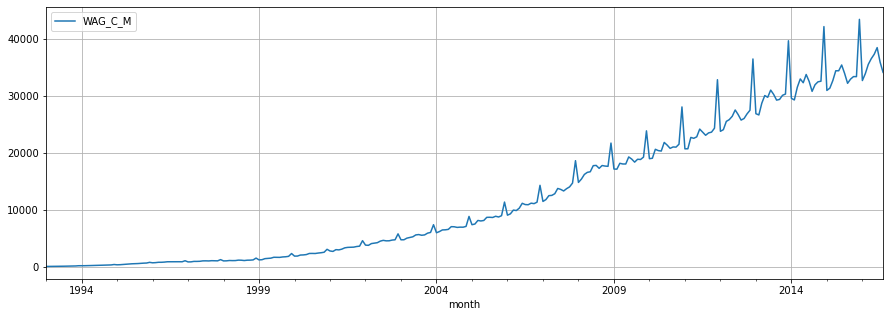

In [6]:
df.plot(figsize=(15,5))
plt.grid(True)
plt.show()

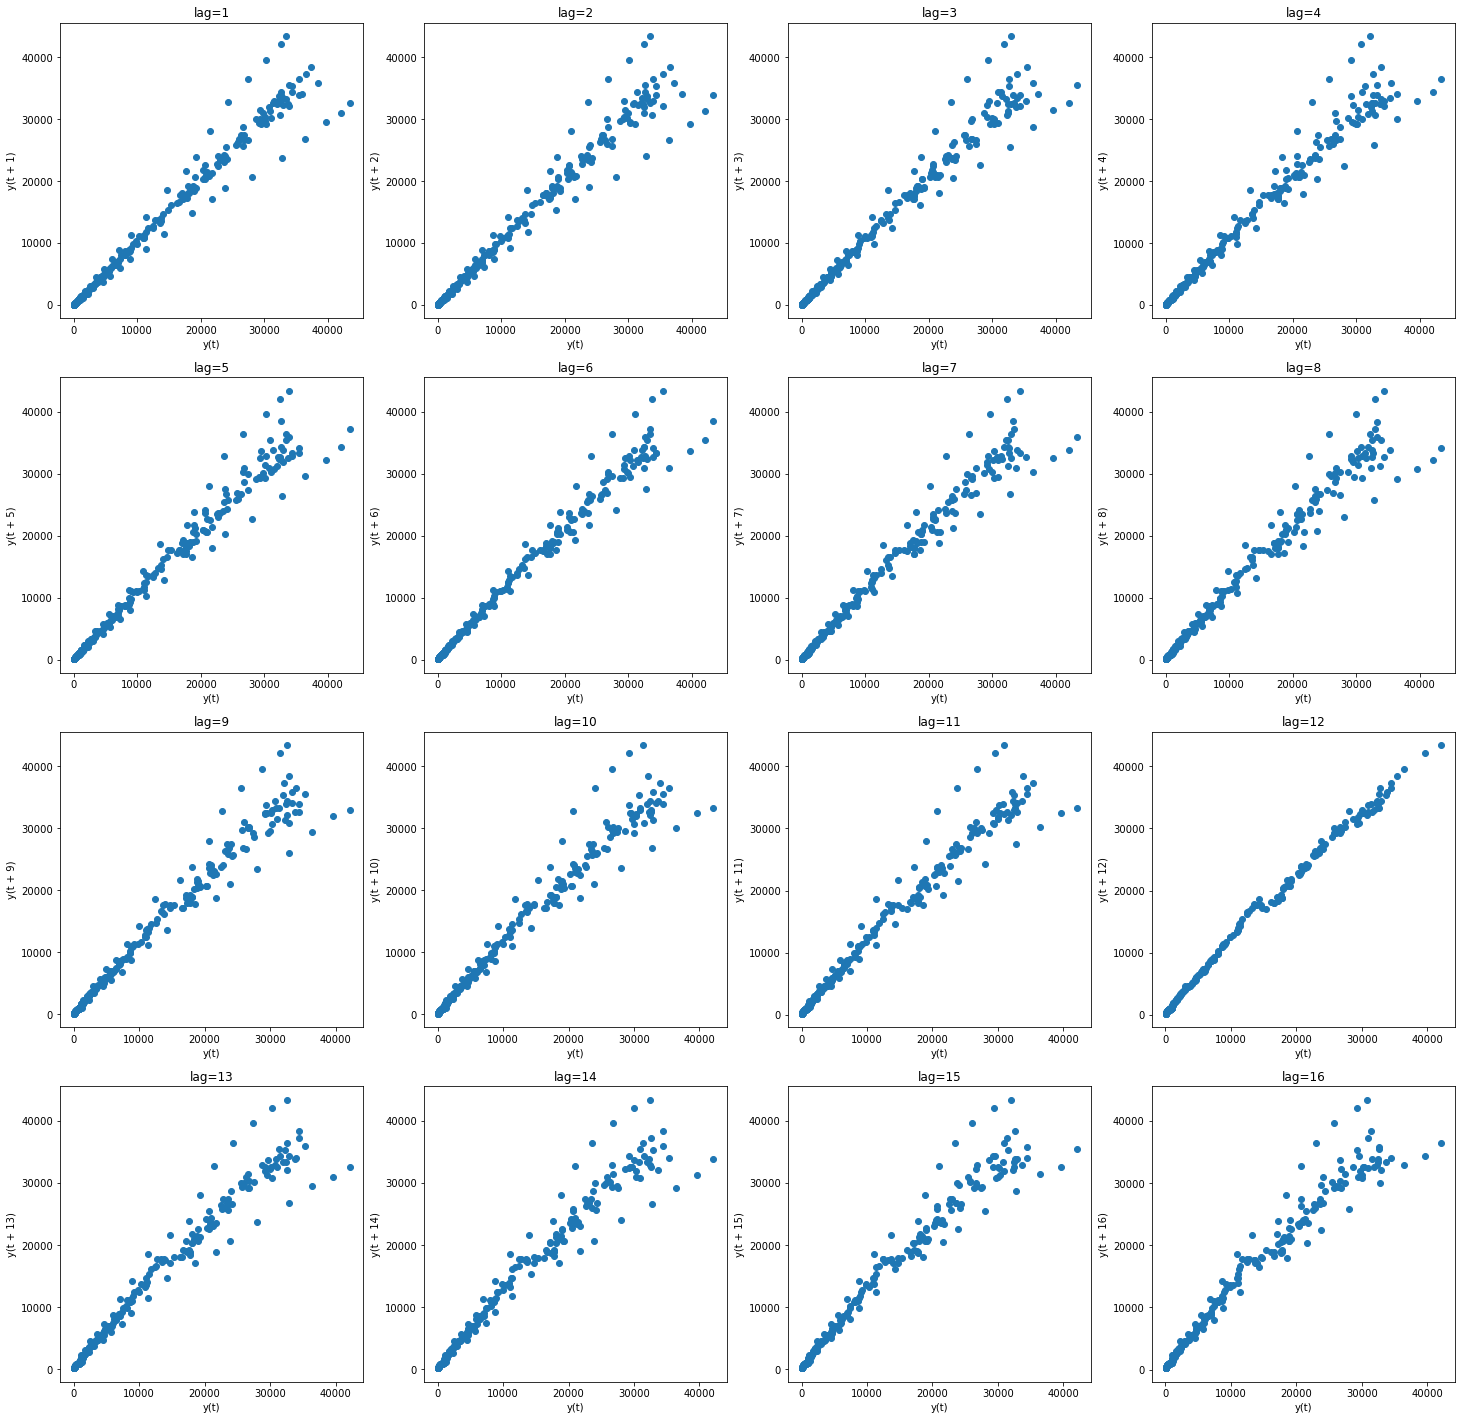

In [7]:
num = 16
fig, ax = plt.subplots(4,4, figsize=(25,25))
for i in range(num):
    pd.plotting.lag_plot(df.WAG_C_M, lag=i+1, ax=ax[i//4][i%4])
    ax[i//4][i%4].set_title("lag={}".format(i+1))
plt.show()

У ряда явно выраженный возрастающий тренд, годовая сезонность (лаг 12), отсутствие циклов, увеличивается дисперсия.

Ряд очевидно не является стационарным.

Анализ стационарности с использованием критерия Дики-Фуллера.

In [8]:
sm.tsa.stattools.adfuller(df)

(0.8134112642935644,
 0.9918495954854734,
 14,
 269,
 {'1%': -3.4548957220044336,
  '5%': -2.8723451788613157,
  '10%': -2.572527778361272},
 3861.7644347401174)

Применение метода Бокса-Кокса для выравнивания дисперсии.

In [9]:
data = boxcox(df.WAG_C_M.values)
df['after_box_cox'] = data[0]
lambda_ = data[1]

<AxesSubplot:xlabel='month'>

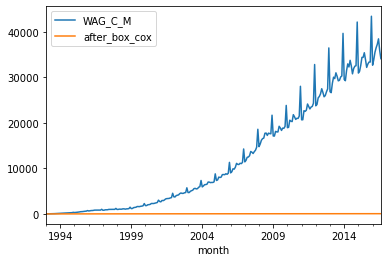

In [10]:
df.plot()

<AxesSubplot:xlabel='month'>

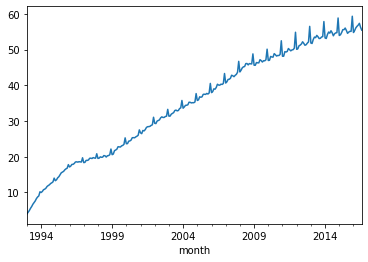

In [11]:
df['after_box_cox'].plot()

In [12]:
sm.tsa.stattools.adfuller(df['after_box_cox'])

(-1.1447539478875959,
 0.6968987634832778,
 13,
 270,
 {'1%': -3.4548039258751206,
  '5%': -2.872304928618605,
  '10%': -2.5725063100137175},
 -16.017167830688777)

После применения преобразования Бокса-Кокса уменьшился коэффициент значимости, получаемый методом Дики-Фуллера (с 0.99 до 0.69), но ряд по прежнему нестационарный.

Применим дифференцирование ряда (вычитание предыдущих значений из последующих) - сезонное (лаг 12), затем с лагом 1.

In [13]:
df['diff12'] = df.after_box_cox - df.after_box_cox.shift(12)

In [14]:
sm.tsa.adfuller(df.diff12.dropna())

(-3.3040788019274525,
 0.014697133494791808,
 6,
 265,
 {'1%': -3.4552699038400827,
  '5%': -2.8725092359464526,
  '10%': -2.5726152830188678},
 -11.623584289767962)

In [15]:
df['diff1'] = df.after_box_cox - df.after_box_cox.shift(1)

In [16]:
sm.tsa.adfuller(df.diff1.dropna())

(-3.3109476076045725,
 0.014396152164950483,
 12,
 270,
 {'1%': -3.4548039258751206,
  '5%': -2.872304928618605,
  '10%': -2.5725063100137175},
 -15.48024723730606)

Уровень значимости гипотезы о нестационарности ряда уменьшается до 0.01 для одинарного и сезонного дифференцирования, что недостаточно для принятия гипотезц и нестационарности, поэтому необходимо применить комбинацию дифференцирований.

In [17]:
df['diff_twice'] = df.diff12 - df.diff12.shift(1)
sm.tsa.adfuller(df.diff_twice.dropna())

(-6.221729105121913,
 5.203603715821631e-08,
 11,
 259,
 {'1%': -3.4558530692911504,
  '5%': -2.872764881778665,
  '10%': -2.572751643088207},
 -4.269995981166346)

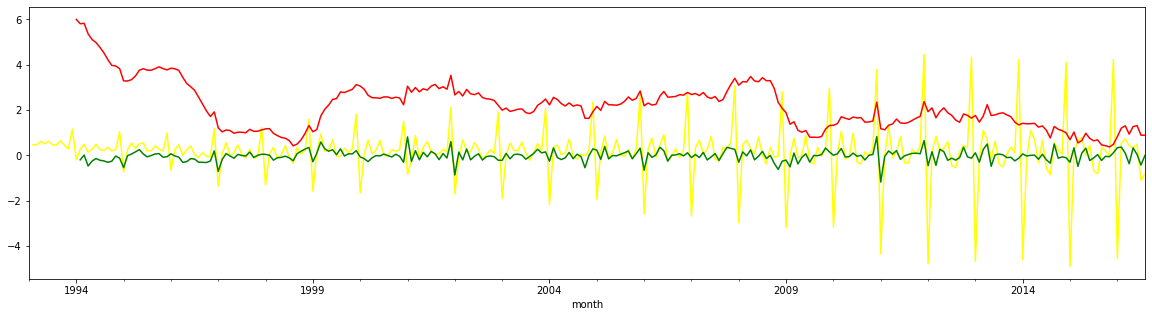

In [18]:
df['diff1'].plot(figsize=(20,5), color='yellow')
df['diff12'].plot(figsize=(20,5), color='red')
df['diff_twice'].plot(figsize=(20,5), color='green')
plt.show()

Для устранения нестационарности ряда применяется двойное дифференцирование - одинарное (с лагом 1) и сезонное (соответствующее лагу 12). График получившихся значений (зеленый) визуально более других похож на белый шум.

Определение гиперпараметров p,d,q,P,D,Q.

q,Q определяются из графика автокорреляции.

p,P определяются из графика частичной автокорреляции.

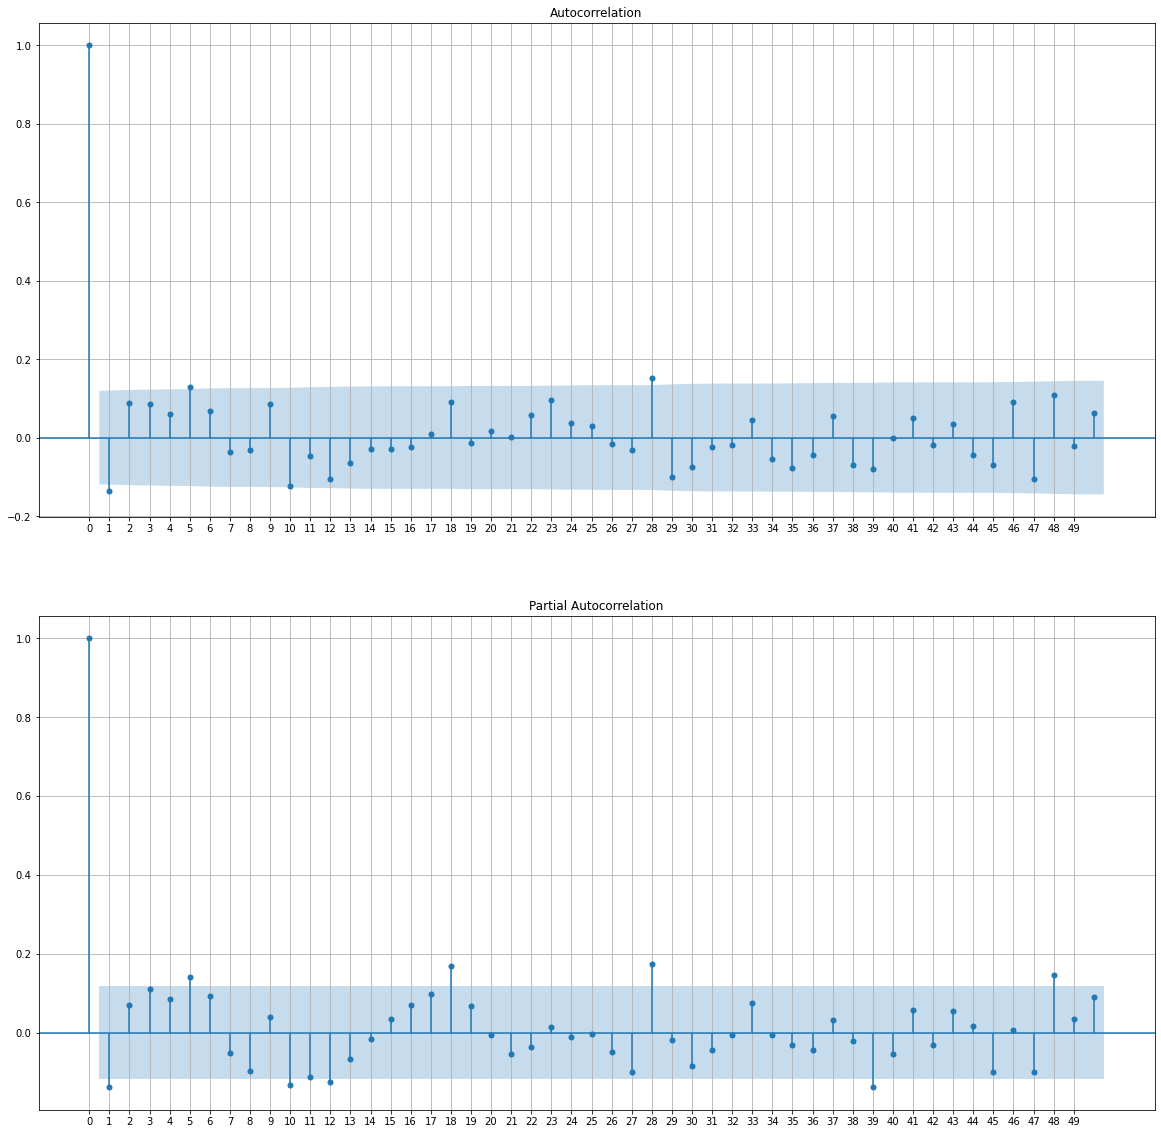

In [19]:
num = 50
fig = plt.figure(figsize=(20,20))

ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(df.diff_twice.dropna().values.squeeze(), lags=num, ax=ax1)
ax1.set_xticks(range(num))
ax1.grid(True)

ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(df.diff_twice.dropna().values.squeeze(), lags=num, ax=ax2)
ax2.set_xticks(range(num))
ax2.grid(True)

plt.show()

Q = 0, q = 10, P = 4, p = 39

Подбор значений гиперпараметров.

In [20]:
ps = range(6)
d = 1
qs = range(6)
Ps = range(2)
D = 1
Qs = range(2)

In [21]:
parameters = product(ps, qs, Ps, Qs)

In [22]:
len(list(parameters))

144

In [23]:
%%time

best_param = []
best_aic = float('inf')
warnings.filterwarnings('ignore')

for p_ in parameters:
    try:
        model = sm.tsa.statespace.SARIMAX(df.after_box_cox, 
                                          order=(p_[0], d, p_[1]), 
                                          seasonal_order=(p_[2], D, p_[3], 12)).fit()
    except:
        print("Problems with parameters {}".format(parameter))
        continue

    if model.aic < best_aic:
        best_param = p_
        best_aic = model.aic
        best_model = model

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 11 µs


In [24]:
best_aic, best_param

(inf, [])

Построение модели прогнозирования SARIMA.

In [25]:
df.index.freq = df.index.inferred_freq

In [26]:
%%time

sarima_model = sm.tsa.statespace.SARIMAX(df.after_box_cox, order=(5, 1, 5), 
                                         seasonal_order=(1, 1, 0, 12)).fit()

CPU times: user 6.34 s, sys: 3.23 ms, total: 6.34 s
Wall time: 6.35 s


In [27]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                       after_box_cox   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(1, 1, [], 12)   Log Likelihood                  24.607
Date:                             Tue, 01 Jun 2021   AIC                            -25.215
Time:                                     07:25:35   BIC                             18.011
Sample:                                 01-01-1993   HQIC                            -7.859
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2286      1.324     -0.173      0.863      -2.824       2.366
ar.L2          0.2306      0.930      0.248      0.804      -1.593       2.054
ar.L3          0.4055      0.586      0.692      0.489      -0.744       1.554
ar.L4          0.1004      1.088      0.092      0.927      -2.033       2.234
ar.L5         -0.6331      0.860     -0.737      0.461      -2.318       1.052
ma.L1          0.0074      1.339      0.006      0.996      -2.617       2.632
ma.L2         -0.1907      1.251     -0.152      0.879      -2.642       2.261
ma.L3         -0.2992      0.929     -0.322      0.747      -2.119       1.521
ma.L4          0.0686      1.265      0.054      0.957      -2.411       2.548
ma.L5          0.8964      1.269      0.707      0.480      -1.590       3.383
ar.S.L12      -0.1331      0.060     -2.205      0.027      -0.251      -0.015
sigma2         0.0479      0.004     12.795      0.000       0.041       0.055
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                52.67
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.71   Skew:                             0.11
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [28]:
sarima_model.aic

-25.214638883441765

Предсказание будущих значений с использованием построенной модели.

In [29]:
prediction = sarima_model.predict(start=df.index[0], end=df.index[-1])

Обратное преобразование Бокса-Кокса

In [30]:
def invboxcox(y,lmbd):
    if lmbd == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(lmbd*y+1)/lmbd)

In [31]:
df.index

DatetimeIndex(['1993-01-01', '1993-02-01', '1993-03-01', '1993-04-01',
               '1993-05-01', '1993-06-01', '1993-07-01', '1993-08-01',
               '1993-09-01', '1993-10-01',
               ...
               '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01',
               '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01',
               '2016-07-01', '2016-08-01'],
              dtype='datetime64[ns]', name='month', length=284, freq='MS')

In [32]:
from dateutil.relativedelta import relativedelta

In [41]:
prediction_range = [df.index[-1]+relativedelta(months=x) for x in range(1,20)]

In [42]:
prediction_future = sarima_model.predict(start=prediction_range[0], end=prediction_range[-1])

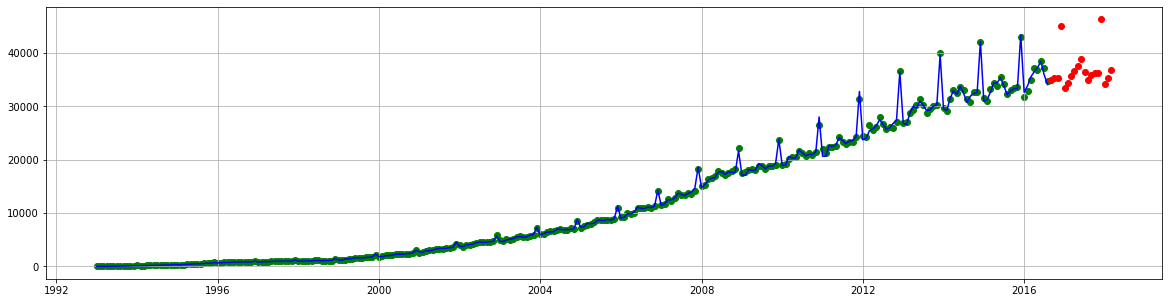

In [43]:
plt.figure(figsize=(20,5))
plt.plot(df.WAG_C_M, c='b')
plt.scatter(df.index, invboxcox(prediction, lambda_), c='g')
plt.scatter(prediction_range, invboxcox(prediction_future, lambda_), c='r')
plt.grid(True)
plt.show()

Оценка остатков

[]

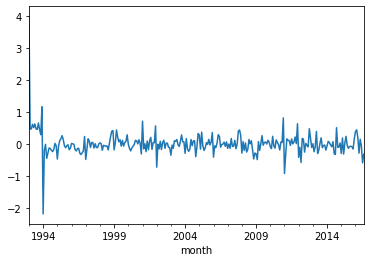

In [36]:
sarima_model.resid.plot()
plt.plot()

In [37]:
sm.tsa.stattools.adfuller(sarima_model.resid)

(-20.527597419484778,
 0.0,
 0,
 283,
 {'1%': -3.453670163592738,
  '5%': -2.8718077069772248,
  '10%': -2.5722411158835796},
 -49.27124882943792)

Остатки являются стационарным процессом и не содержат в себе какой-либо полезной информации неслучайного характера, которую можно было бы учесть при прогнозировании.